# **Corto 1** 

**Daniela Navas**

---

## **Task** - Frozen Lake

El juego de Frozen Lake consiste en llevar al personaje de un punto de inicio hasta la meta, cuidando no caer en ningún agujero, además se debe considerar que algunas veces el jugador no se moverá en la dirección esperada debido a la naturaleza resbaladiza del hielo.  

Este juego se desempeña en un tablero de 4x4, estando siempre la meta en el último cuadro. Los agujeros están distribuidos de forma aleatoria, además que cada vez que se genere el juego debe de generarse un nuevo mundo.

Para este task, no debe implementar todo desde cero, por el contrario debe centrarse en la definición de la política o método de aprendizaje a ser utilizado (Q-learning, MDP libre de modelos, MDP basado en modelos, etc). Por ello, usará la librería de Gymnasium (previamente soportada por OpenIA) para poder desarrollar una solución para este juego.

Usando la mencionada librería tendrá implementandos ya el espacio de acciones, el espacio observable, el estado inicial, el conjunto de acciones, los finales de episodio, además de funciones que le darán información. Para mayor información visiten este [enlace](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
.  

En conclusión, su trabajo para este task es implementar un agente inteligente que resuelva el juego de Frozen Lake con el argumento de slippery=True, usando un algoritmo de aprendizaje por refuerzo.  

---

**Q-learning**

Se usará Q-learning como método de aprendizaje, ya que maneja entornos estocásticos, como el que presenta la opción de *slippery=True* con una incertidumbre en los movimientos debido al hielo resbaladizo. Aprende la política óptima a través de la exploración y explotación, sin necesidad de un modelo del entorno. Además, es sencillo de implementar, escalable y se adapta perfectamente a los entornos discretos y dinámicos proporcionados por Gymnasium.

Tasa de éxito en 100 episodios: 100.00%


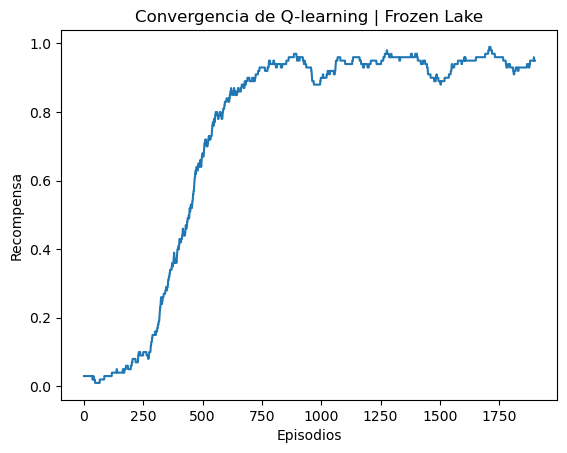

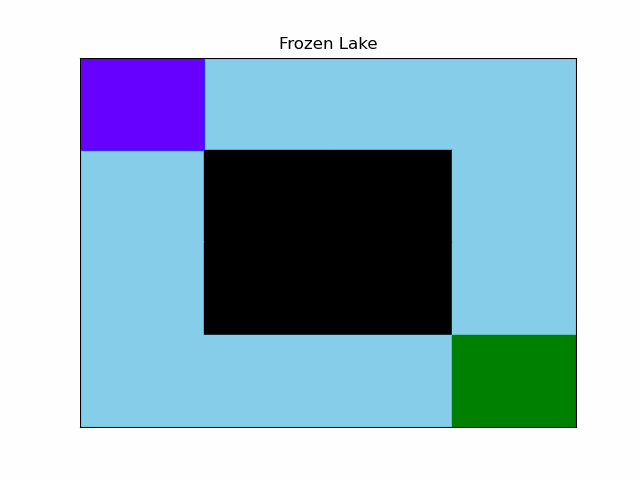

In [3]:
# Librerias
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
import io
from IPython.display import display, Image
import random

# Q-learning
alpha = 0.1           # Tasa de aprendizaje
gamma = 0.99          # Factor de descuento
epsilon = 1.0         # Tasa de exploración
epsilon_decay = 0.995    
epsilon_min = 0.01         
episodes = 2000       # Episodios

# ------------------------------------------------------------------
#
# Función para generar mapa
#
# ------------------------------------------------------------------
def generate_random_map(size=4, p_hole=0.25):      # Mapa aleatorio con max 4 agujeros
    map_ = np.full((size, size), "F", dtype="U1")  # Crear un mapa lleno de 'F' (Frozen)
    map_[0, 0] = "S"                               # Colocar la posición de inicio en la esquina superior izquierda
    map_[-1, -1] = "G"                             # Colocar la meta en la esquina inferior derecha
    
    # Colocar hasta 4 agujeros aleatorios ('H')
    holes = random.sample(range(1, size * size - 1), k=min(4, size * size - 2))
    for hole in holes:
        i, j = divmod(hole, size)
        map_[i, j] = "H"  # Colocar agujeros aleatorios en el mapa
    
    return ["".join(row) for row in map_]  # Convertir mapa en una lista de strings


# Crear el entorno FrozenLake con un mapa aleatorio, con argumento is_slippery como True
env = gym.make("FrozenLake-v1", is_slippery=True, desc=generate_random_map(), render_mode=None)
n_states = env.observation_space.n    # Número de estados
n_actions = env.action_space.n        # Número de acciones posibles

Q_table = np.zeros((n_states, n_actions)) # Inicializar tabla Q (de dimensiones [estados x acciones] con valores 0)
rewards = [] # Lista para almacenar las recompensas obtenidas durante el entrenamiento

# /////////////////////////////////////////////////
#                                                //
# Entrenamiento de Modelo                        //
#                                                //
# /////////////////////////////////////////////////
for episode in range(episodes):
    state, _ = env.reset()  # Inicializar el entorno y obtener el estado inicial
    total_reward = 0        # Recompensa total acumulada durante el episodio
    done = False            # Bandera si el episodio yaa termino
    
    while not done:  # Ejecutar el episodio hasta que termine
        # Def si explorar o explotar usando epsilon-greedy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Exploración (selección aleatoria de acción)
        else:
            action = np.argmax(Q_table[state, :])  # Explotación (selección de la mejor acción conocida)
        
        # Realizar la acción y obtener el siguiente estado, recompensa y si ha terminado el episodio
        next_state, reward, done, _, _ = env.step(action)  
        
        # Actualizar la tabla Q usando la ecuación de Q-learning
        Q_table[state, action] = Q_table[state, action] + alpha * (
            reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action]
        )
        
        # Actualizar el estado actual
        state = next_state
        total_reward += reward # Sumar la recompensa obtenida
    
    rewards.append(total_reward)                         # Guardar la recompensa del episodio
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Reducir epsilon para hacer menos exploración
    
# /////////////////////////////////////////////////
#                                                //
# Evaluación del agente                          //
#                                                //
# /////////////////////////////////////////////////
successes = 0        # Contador de episodios exitosos (donde llega a la meta)
test_episodes = 100  # Número de episodios para probar el agente
optimal_path = []    # Lista para almacenar el mejor camino encontrado

# Evaluación en episodios de prueba
for _ in range(test_episodes):
    state, _ = env.reset()     # Inicializar el entorno para cada prueba
    done = False
    episode_path = []          # Lista para almacenar el camino seguido en el episodio
    while not done:
        episode_path.append(state)                    # Guardar el estado en el camino
        action = np.argmax(Q_table[state, :])         # Tomar la acción con la mayor Q
        state, reward, done, _, _ = env.step(action)
    if reward == 1:                  # Si el agente llega a la meta
        successes += 1               # Contar el éxito
        optimal_path = episode_path  # Guardar el camino exitoso

# MOSTRAR TASA DE ÉXITO
print(f"Tasa de éxito en {test_episodes} episodios: {successes / test_episodes * 100:.2f}%")

# /////////////////////////////////////////////////
#                                                //
# GRÁFICA DE CONVERGENCIA                        //
#                                                //
# /////////////////////////////////////////////////
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.title("Convergencia de Q-learning | Frozen Lake")
plt.show()

# *************************************************************************************************

# ------------------------------------------------------------------
#
# Función para hacer GIF | Mostrar gráficamente el camino
#
# ------------------------------------------------------------------
def create_gif(optimal_path):
    size = int(np.sqrt(n_states))  # Tamaño del mapa (4x4)
    lake = np.array(["F"] * n_states).reshape((size, size))  # Crear el mapa base
    lake[0, 0] = "S"                                         # Colocar la casilla de inicio
    lake[-1, -1] = "G"                                       # Colocar la casilla de meta
    
    env_unwrapped = env.unwrapped  # Acceder al entorno subyacente para obtener los agujeros
    for state in range(n_states):
        if env_unwrapped.desc.flatten()[state] == b"H":
            i, j = divmod(state, size)
            lake[i, j] = "H"  # Colocar agujeros en el mapa
    
    # Colores para las casillas (hielo, agujerso, inicio, meta)
    colors = {"F": "skyblue", "H": "black", "S": "magenta", "G": "green"}
    frames = []   # Lista para almacenar los frames del GIF
    
    # Generar los frames del GIF recorriendo el camino del agente
    for step, state in enumerate(optimal_path):
        fig, ax = plt.subplots()

        # Dibujar todos los cuadros del mapa
        for i in range(size):
            for j in range(size):
                ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color=colors[lake[i, j]]))
        
        # Dibujar el camino recorrido por el agente en azul
        for s in optimal_path[:step+1]:
            i, j = divmod(s, size)
            ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color="blue", alpha=0.6))

        ax.set_xticks([])     # Quitar marcas en el eje x y y
        ax.set_yticks([])     
        ax.set_xlim(0, size)  # Establecer límites del gráfico
        ax.set_ylim(0, size)  
        plt.title("Frozen Lake")  # Título

        # Guardar el frame
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())  # Convertir el gráfico a imagen
        frames.append(image)                                 # Añadir el frame a la lista de frames
        plt.close(fig)                                       # Cerrar la figura para no sobrecargar la memoria

    # Generar un frame final | Juego Ganado
    fig, ax = plt.subplots()
    for i in range(size):
        for j in range(size):
            ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color=colors[lake[i, j]]))

    for s in optimal_path:
        i, j = divmod(s, size)
        ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color="blue", alpha=0.6))

    i, j = divmod(n_states - 1, size)  
    ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color="blue", alpha=0.6))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    plt.title("Frozen Lake")

    # Guardar el frame final y agregarlo a los frames
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(image)
    plt.close(fig)
    
    # Mostrar el GIF final con todos los frames generados
    buffer = io.BytesIO()
    imageio.mimsave(buffer, frames, duration=0.5, format='GIF')  # Guardar el GIF
    display(Image(data=buffer.getvalue()))                       # Mostrar el GIF en la interfaz

# Crear y mostrar el GIF con la solución
if optimal_path:
    create_gif(optimal_path) # Llamar a la función para crear y mostrar el GIF con el camino del agente

---

**GITHUB:**
https://github.com/danielanavas2002/InteligenciaArtificial/tree/main/Corto/Corto01

**VIDEO DE FUNCIONAMIENTO:** https://youtu.be/7b1zcZVFy9E
